## **ECON 470 Hwk2-3**

**Author:** Ilse Novis 

**Date:** 2/21/2025  

[GitHub Repository](https://github.com/ilsenovis18/ECON470HW2)

\newpage

In [1]:
%matplotlib inline

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from causalinference import CausalModel
import os
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.neighbors import NearestNeighbors
from IPython.display import Markdown, display
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
# Read in data
data=pd.read_csv('/Users/ilsenovis/Documents/GitHub/ECON470HW2/data/output/HCRIS_Clean_Data.csv')
hcris_data_preclean=pd.read_csv('/Users/ilsenovis/Documents/GitHub/ECON470HW2/data/output/HCRIS_Data_preclean.csv')

In [4]:
# Convert 'fy_start' to datetime to extract the year
hcris_data_preclean['fy_start'] = pd.to_datetime(hcris_data_preclean['fy_start'], errors='coerce')
hcris_data_preclean['year'] = hcris_data_preclean['fy_start'].dt.year

## **Summarize Data**

#### **Question 1:** 
<br> *How many hospitals filed more than one report in the same year?*

In [5]:
# Count hospitals that filed more than one report in the same year
hospital_counts = hcris_data_preclean.groupby(['provider_number', 'year']).size().reset_index(name='report_count')
multiple_reports = hospital_counts[hospital_counts['report_count'] > 1]

# Count number of hospitals per year
hospitals_over_time = multiple_reports.groupby('year')['provider_number'].nunique()

# Remove duplicate reports by keeping only the first occurrence per hospital per year
unique_hospitals = data.drop_duplicates(subset=['provider_number', 'year'])

# Count the number of unique hospital IDs (Medicare provider numbers)
unique_hospital_count = unique_hospitals['provider_number'].nunique()

display(Markdown(f"#### **Number of Unique Hospital IDs:** {unique_hospital_count}"))

#### **Number of Unique Hospital IDs:** 6739

In [6]:
hcris_data_preclean.groupby(['provider_number', 'year']).size().value_counts()

# Count duplicate reports per provider per year
dup_count = hcris_data_preclean.groupby(['provider_number', 'year']).size().reset_index(name='total_reports')

# Count duplicate reports per year
dup_count['dup_report'] = dup_count['total_reports'] > 1

# Summarize duplicates per year
dup_summary = dup_count.groupby('year')['dup_report'].sum().reset_index()
#print(dup_summary)

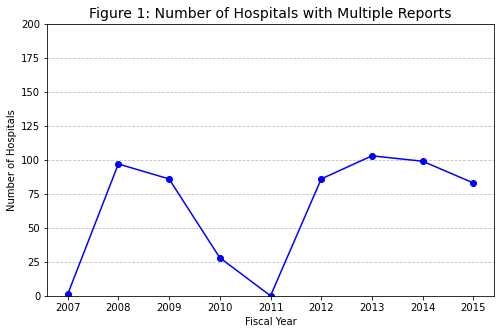

In [7]:
# Line plot for hospitals with multiple reports
plt.figure(figsize=(8, 5))
plt.plot(dup_summary['year'].values, dup_summary['dup_report'].values, marker='o', linestyle='-', color='blue')

# Set y-axis to log scale to handle large jumps
plt.xticks(range(2007, 2016))

plt.title('Figure 1: Number of Hospitals with Multiple Reports', fontsize=14)
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Hospitals')
plt.ylim(0, 200)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

\newpage

#### **Question 2:** 
<br> *After removing/combining multiple reports, how many unique hospital IDs (Medicare provider numbers) exist in the data?*

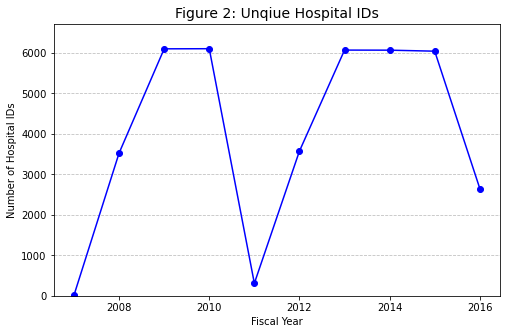

In [8]:
#dup_summary = dup_count.groupby('year')['total_reports'].sum().reset_index()
hosp_count = data.groupby('year').size().reset_index(name='hosp_count')

# Count of unique hospitals per year
plt.figure(figsize=(8, 5))
plt.plot(hosp_count['year'].values, hosp_count['hosp_count'].values,
         marker='o', linestyle='-', color='blue')
plt.title('Figure 2: Unqiue Hospital IDs', fontsize=14)
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Hospital IDs')
plt.ylim(0, hosp_count['hosp_count'].max() * 1.1)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

\newpage

#### **Question 3:** 
<br> *What is the distribution of total charges (tot_charges in the data) in each year?*

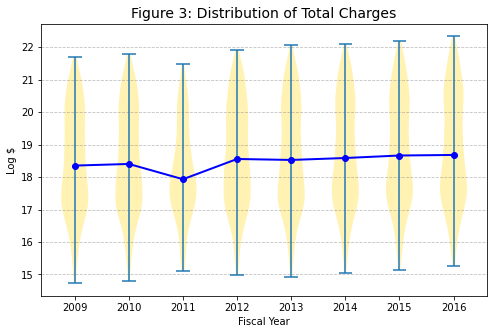

In [9]:
charge_data = data.copy()

# Drop rows where 'tot_charges' is NaN 
charge_data = charge_data.dropna(subset=['tot_charges'])

# Comput 1st and 99th percentiles
charge_data['tot_charges_low'] = charge_data.groupby('year')['tot_charges'].transform(lambda x: np.nanpercentile(x, 1))
charge_data['tot_charges_high'] = charge_data.groupby('year')['tot_charges'].transform(lambda x: np.nanpercentile(x, 99))

# Filter out extreme vlaues and missing data
charge_data = charge_data[
    (charge_data['tot_charges'] > charge_data['tot_charges_low']) &
    (charge_data['tot_charges'] < charge_data['tot_charges_high']) &
     charge_data['tot_charges'].notna() &
     (charge_data['year'] > 2008)
]

# Compute log of total charges
charge_data['log_charge'] = np.log(charge_data['tot_charges'])

# Prepare data for violin plot
years = sorted(charge_data['year'].unique())
charge_violin_data = [charge_data[charge_data['year'] == y]['log_charge'].dropna().values for y in years]

# Plot distribution of total charges
fig, ax = plt.subplots(figsize=(8, 5))
parts = ax.violinplot(charge_violin_data, positions=years, showmedians=False)

# Customize Violin Plot
for pc in parts['bodies']:
    pc.set_facecolor('gold')
    pc.set_alpha(0.3)

# Add median line
median = charge_data.groupby('year')['log_charge'].median()
plt.plot(years, median.values, marker='o', linestyle='-', color='blue', linewidth=2)

# Format plot
plt.title('Figure 3: Distribution of Total Charges', fontsize=14)
plt.xlabel('Fiscal Year')
plt.ylabel('Log $')
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

\newpage

#### **Question 4:** 
<br> *What is the distribution of estimated prices in each year?*

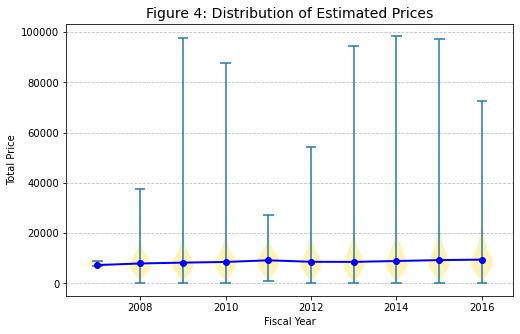

In [10]:
if not isinstance(data, pd.DataFrame):
    data = pd.read_csv(data)

# Price Calculation
data['discount_factor'] = 1 - data['tot_discounts'] / data['tot_charges']
data['price_num'] = (
    (data['ip_charges'] + data['icu_charges'] + data['ancillary_charges']) * 
    data['discount_factor']
) - data['tot_mcare_payment']
data['price_denom'] = data['tot_discharges'] - data['mcare_discharges']
data['price'] = data['price_num'] / data['price_denom']

# Replace invalid denominators (zero or NaN) with NaN
data['price_denom'] = np.where(data['price_denom'] > 0, data['price_denom'], np.nan)

# Compute price only for valid values
data['price'] = data['price_num'] / data['price_denom']

# Filtering the data
price_data = data[
    (data['price_denom'] > 100) &
    (~data['price_denom'].isna()) &
    (data['price_num'] > 0) &
    (~data['price_num'].isna()) &
    (data['price'] < 100000) &
    (data['beds'] > 30) &
    (~data['beds'].isna())
]

# Prepare for Violin plot
years = sorted(price_data['year'].unique())
price_violin_data = [price_data[price_data['year'] == y]['price'].dropna().values for y in years]

# Plot distribution of total charges
fig, ax = plt.subplots(figsize=(8, 5))
parts = ax.violinplot(price_violin_data, positions=years, showmedians=False)

# Customize violin plot
for pc in parts['bodies']:
    pc.set_facecolor('gold')
    pc.set_alpha(0.3)

# Add median line
median = price_data.groupby('year')['price'].median()
plt.plot(years, median.values, marker='o', linestyle='-', color='blue', linewidth=2)

# Format plot
plt.title('Figure 4: Distribution of Estimated Prices', fontsize=14)
plt.xlabel('Fiscal Year')
plt.ylabel('Total Price')
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

\newpage

## **Estimate ATEs**

#### **Question 5:** 
<br> *Calculate the average price among penalized versus non-penalized hospitals.*

In [11]:
# Load dataset
hcris_data = pd.read_csv('/Users/ilsenovis/Documents/GitHub/ECON470HW2/data/output/HCRIS_Clean_Data.csv')

# Filter data to only include year 2012
hcris_2012 = hcris_data[hcris_data['year'] == 2012].copy()

# Handle missing payments
hcris_2012['hvbp_payment'] = hcris_2012['hvbp_payment'].fillna(0)
hcris_2012['hrrp_payment'] = hcris_2012['hrrp_payment'].fillna(0).abs()

# Calculate estimated price
hcris_2012['discount_factor'] = 1 - (hcris_2012['tot_discounts'] / hcris_2012['tot_charges'])
hcris_2012['price_num'] = (hcris_2012['ip_charges'] + hcris_2012['icu_charges'] + hcris_2012['ancillary_charges']) * hcris_2012['discount_factor'] - hcris_2012['tot_mcare_payment']
hcris_2012['price_denom'] = hcris_2012['tot_discharges'] - hcris_2012['mcare_discharges']
hcris_2012['price'] = hcris_2012['price_num'] / hcris_2012['price_denom']

# Define penalty
hcris_2012['penalty'] = (hcris_2012['hrrp_payment'] + hcris_2012['hvbp_payment']) < 0

# Apply data cleaning filters
hcris_2012 = hcris_2012[(hcris_2012['price_denom'] > 100) & (hcris_2012['price_num'] > 0) & (hcris_2012['price'] > 0)]
hcris_2012 = hcris_2012[hcris_2012['beds'] > 30]
hcris_2012 = hcris_2012[hcris_2012['price'] < 100000]  

# Calculate mean price for penalized vs non-penalized hospitals
mean_penalized = hcris_2012.loc[hcris_2012['penalty'] == 1, 'price'].mean()
mean_non_penalized = hcris_2012.loc[hcris_2012['penalty'] == 0, 'price'].mean()

# Create formatted results
price_summary = pd.DataFrame({
    "Penalty Status": ["Penalized", "Non-Penalized"],
    "Average Price": [f"${mean_penalized:,.2f}", f"${mean_non_penalized:,.2f}"]
})

# Sample DataFrame for price summary
price_summary = pd.DataFrame({
    "Penalty Status": ["Penalized", "Non-Penalized"],
    "Average Price": [10171.54, 9651.82]
})

# Ensure "results" directory exists
os.makedirs("results", exist_ok=True)

# Save table as Markdown
md_table = price_summary.to_markdown(index=False)
with open("results/table1_penalty_status.md", "w") as f:
    f.write("#### **Table 1: Avg. Price for Penalty Status**\n\n")
    f.write(md_table)

# Save table as LaTeX for PDF conversion
latex_table = price_summary.to_latex(index=False, escape=False, column_format="ll")
with open("results/table1_penalty_status.tex", "w") as f:
    f.write("\\section*{Table 1: Avg. Price for Penalty Status}\n")
    f.write(latex_table)

# Display table in Notebook (for Jupyter)
display(Markdown("#### **Table 1: Avg. Price for Penalty Status**"))
display(Markdown(md_table))


#### **Table 1: Avg. Price for Penalty Status**

| Penalty Status   |   Average Price |
|:-----------------|----------------:|
| Penalized        |        10171.5  |
| Non-Penalized    |         9651.82 |

\newpage

#### **Question 6:** 
<br> *Split hospitals into quartiles based on bed size. To do this, create 4 new indicator variables, where each variable is set to 1 if the hospital’s bed size falls into the relevant quartile. Provide a table of the average price among treated/control groups for each quartile.*

In [12]:
hcris_2012['beds_quartile'] = pd.qcut(hcris_2012['beds'], 4, labels=[1, 2, 3, 4])

# Create indicator variables for each quartile
for i in range(1, 5):
    hcris_2012[f'quartile_{i}'] = (hcris_2012['beds_quartile'] == i).astype(int)


# Calculate average price for treated and control groups within each quartile
Avg_per_group = []
for i in range(1, 5):
    treated_mean = hcris_2012.loc[(hcris_2012[f'quartile_{i}'] == 1) & (hcris_2012['penalty'] == 1), 'price'].mean()
    control_mean = hcris_2012.loc[(hcris_2012[f'quartile_{i}'] == 1) & (hcris_2012['penalty'] == 0), 'price'].mean()
    Avg_per_group.append({'Quartile': i, 'Penalized Avg. Price': round(treated_mean, 2), 'Non Penalized Avg. Price': round(control_mean, 2)})

results_df = pd.DataFrame(Avg_per_group)
results_df[['Penalized Avg. Price', 'Non Penalized Avg. Price']] = results_df[
    ['Penalized Avg. Price', 'Non Penalized Avg. Price']
].applymap(lambda x: f"${x:,.2f}")

# Ensure "results" directory exists
os.makedirs("results", exist_ok=True)

# Save table as Markdown
md_table = results_df.to_markdown(index=False)
with open("results/table2_avg_price_quartiles.md", "w") as f:
    f.write("#### **Table 2: Avg. Price Among Treated & Control Groups**\n\n")
    f.write(md_table)

# Save table as LaTeX for PDF conversion
latex_table = results_df.to_latex(index=False, escape=False, column_format="lcc")
with open("results/table2_avg_price_quartiles.tex", "w") as f:
    f.write("\\section*{Table 2: Avg. Price Among Treated & Control Groups}\n")
    f.write(latex_table)

# Display table in Notebook (for Jupyter)
display(Markdown("#### **Table 2: Avg. Price Among Treated & Control Groups**"))
display(Markdown(md_table))

#### **Table 2: Avg. Price Among Treated & Control Groups**

|   Quartile | Penalized Avg. Price   | Non Penalized Avg. Price   |
|-----------:|:-----------------------|:---------------------------|
|          1 | $8,888.99              | $7,694.39                  |
|          2 | $10,029.57             | $8,181.43                  |
|          3 | $11,146.07             | $9,577.29                  |
|          4 | $12,954.61             | $11,629.75                 |

\newpage

#### **Question 7:** 
<br> *Find the average treatment effect using each of the following estimators, and present your results in a single table:*

In [13]:

# Assign quartile categories to beds
hcris_2012['bed_quartile'] = pd.qcut(hcris_2012['beds'], 4, labels=False)

# Define treatment, outcome, and covariates
y = hcris_2012['price'].values
D = hcris_2012['penalty'].values
X = hcris_2012[['bed_quartile']].values

# Create causal model
causal_model = CausalModel(Y=y, D=D, X=X)

# Create results DataFrame
results = pd.DataFrame(index=['ATE', 'SE'], columns=['INV', 'MAH', 'IPW', 'OLS'])

# Estimate ATE using different methods
## Inverse Variance Matching
causal_model.est_via_matching(weights='inv', matches=1, bias_adj=True)
results.loc['ATE', 'INV'] = causal_model.estimates['matching']['ate']
results.loc['SE', 'INV'] = causal_model.estimates['matching']['ate_se']

## Mahalanobis Distance Matching
causal_model.est_via_matching(weights='maha', matches=1, bias_adj=True)
results.loc['ATE', 'MAH'] = causal_model.estimates['matching']['ate']
results.loc['SE', 'MAH'] = causal_model.estimates['matching']['ate_se']

## Propensity Score Weighting
causal_model.est_propensity()
causal_model.est_via_weighting()
results.loc['ATE', 'IPW'] = causal_model.estimates['weighting']['ate']
results.loc['SE', 'IPW'] = causal_model.estimates['weighting']['ate_se']

## OLS Regression
causal_model.est_via_ols(adj=2)
results.loc['ATE', 'OLS'] = causal_model.estimates['ols']['ate']
results.loc['SE', 'OLS'] = causal_model.estimates['ols']['ate_se']

# Format as currency
results = results.applymap(lambda x: f"${x:,.6f}")

# Ensure "results" directory exists
os.makedirs("results", exist_ok=True)

# Save table as Markdown for PDF export
md_table = results.to_markdown()
with open("results/table3_ATE_estimates.md", "w") as f:
    f.write("#### **Table 3: ATE Estimates**\n\n")
    f.write(md_table)

# Save table as LaTeX for direct PDF inclusion
latex_table = results.to_latex(escape=False, column_format="lccc")
with open("results/table3_ATE_estimates.tex", "w") as f:
    f.write("\\section*{Table 3: ATE Estimates}\n")
    f.write(latex_table)

# Display table in Jupyter Notebook
display(Markdown("#### **Table 3: ATE Estimates**"))
display(Markdown(md_table))

#### **Table 3: ATE Estimates**

|     | INV           | MAH           | IPW           | OLS           |
|:----|:--------------|:--------------|:--------------|:--------------|
| ATE | $1,482.630561 | $1,482.630561 | $1,492.327633 | $1,492.601994 |
| SE  | $410.488187   | $410.488187   | $410.375889   | $410.384427   |

\newpage

#### **Question 8:** 
<br> *With these different treatment effect estimators, are the results similar, identical, very different?*

<br>
The estimated ATEs across the four different estimators—**Inverse Variance Matching (INV), Mahalanobis Matching (MAH), Inverse Propensity Weighting (IPW), and Ordinary Least Squares (OLS)**—are highly consistent with each other.
- The ATE estimates range from $1,482.63 (INV/MAH) to $1,492.60 (OLS), a difference of only $10, which is relatively small in magnitude.
- The INV and MAH Matching estimators produce identical results, suggesting that both methods are capturing similar patterns in the data.
- The IPW and OLS estimates are slightly higher but remain within a very narrow range, indicating that the choice of estimation method does not significantly impact the estimated treatment effect.

Additionaly, the Standard Errors (SEs) across all estimators are nearly identical (~$410), implying that the level of precision and uncertainty surrounding these estimates remains consistent regardless of the estimation technique used.

#### **Question 9:** 
<br> *Do you think you’ve estimated a causal effect of the penalty? Why or why not? (just a couple of sentences)*

<br>
While I have estimated an association between the penalty and hospital prices, the results cannot be used to definitively claim causality. The methods used—**matching and weighting**—help control for observable confounders, but unobserved factors (e.g., hospital quality, patient demographics, or other financial incentives) could still influence both the penalty and pricing. 

Additionally, penalties are not randomly assigned, meaning there may be selection bias that our estimators cannot fully eliminate. A stronger causal claim would require an instrumental variable or a randomized experiment.

#### **Question 10:** 
<br> *Briefly describe your experience working with these data (just a few sentences). Tell me one thing you learned and one thing that really aggravated or surprised you.*
<br>
This data was extremely frustrating when trying to merge, and somehow, even after restarting maybe 5 times, my data is still incomplete (2011: multiple reports & unique hospital IDs). However, I was suprised by the variation between charges and estiamted total prices for all hospitals.